In [32]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

!sudo apt-get install -y xvfb ffmpeg
!pip install 'xvfbwrapper==0.2.9'
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
# You will need this specific version to run this notebook
!pip install 'tf-agents==0.4.0'
!pip install gast
!pip install Box2D

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn

import abc
import base64
import imageio
import io
import IPython
import numpy as np
import PIL.Image
import pyvirtualdisplay
import tensorflow_probability as tfp
import numpy as np
import shutil
import tempfile
import zipfile

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Exploration Techniques

# Multi-armed bandit

In probability theory, the multi-armed bandit problem (sometimes called the K or N-armed bandit problem) is a problem in which a fixed limited set of resources must be allocated between competing (alternative) choices in a way that maximizes their expected gain, when each choice's properties are only partially known at the time of allocation, and may become better understood as time passes or by allocating resources to the choice. This is a classic reinforcement learning problem that exemplifies the **exploration–exploitation tradeoff** dilemma (i.e. finding a balance between **exploration** (of uncharted territory) and **exploitation** (of current knowledge)). The name comes from imagining a gambler at a row of slot machines (sometimes known as **"one-armed bandits"**), who has to decide which machines to play, how many times to play each machine and in which order to play them, and whether to continue with the current machine or try a different machine. The multi-armed bandit problem also falls into the broad category of stochastic scheduling.

In the problem, each machine provides a random reward from a probability distribution specific to that machine. The objective of the gambler is to maximize the sum of rewards earned through a sequence of lever pulls. The crucial tradeoff the gambler faces at each trial is between **"exploitation"** of the machine that has the highest expected payoff and **"exploration"** to get more information about the expected payoffs of the other machines. The trade-off between exploration and exploitation is also faced in machine learning. In practice, multi-armed bandits have been used to model problems such as managing research projects in a large organization like a science foundation or a pharmaceutical company. In early versions of the problem, the gambler begins with no initial knowledge about the machines.

Herbert Robbins in 1952, realizing the importance of the problem, constructed convergent population selection strategies in "some aspects of the sequential design of experiments". A theorem, the Gittins index, first published by John C. Gittins, gives an optimal policy for maximizing the expected discounted reward.

There are many practical applications of the bandit model, for example:
* *clinical trials* investigating the effects of different experimental treatments while minimizing patient losses
* *adaptive routing* efforts for minimizing delays in a network,
* *financial portfolio design*

## Model of the Multi-armed bandit
The multi-armed bandit (**bandit** or MAB) can be seen as a set of real distributions $B = \{R_1, \dots ,R_K\}$, each distribution being associated with the rewards delivered by one of the $K \in \mathbb{N}^+$ levers. Let $\mu_1, \dots , \mu_K$ be the mean values associated with these reward distributions. The gambler iteratively plays one lever per round and observes the associated reward. The objective is to maximize the sum of the collected rewards. The horizon $H$ is the number of rounds that remain to be played. The bandit problem is formally equivalent to a one-state *Markov decision process*. The *regret* $\rho$ after $T$ rounds is defined as the expected difference between the reward sum associated with an optimal strategy and the sum of the collected rewards: 

$$\rho = T \mu^* - \sum_{t=1}^T \widehat{r}_t$$

where $\mu^*$ is the maximal reward mean, $\mu^* = \max_k \{ \mu_k \}$, and $\widehat{r}_t$ is the reward in round $t$.

A *zero-regret strategy* is a strategy whose average regret per round $\rho / T$ tends to zero with probability 1 when the number of played rounds tends to infinity. Intuitively, zero-regret strategies are guaranteed to converge to a (not necessarily unique) optimal strategy if enough rounds are played.

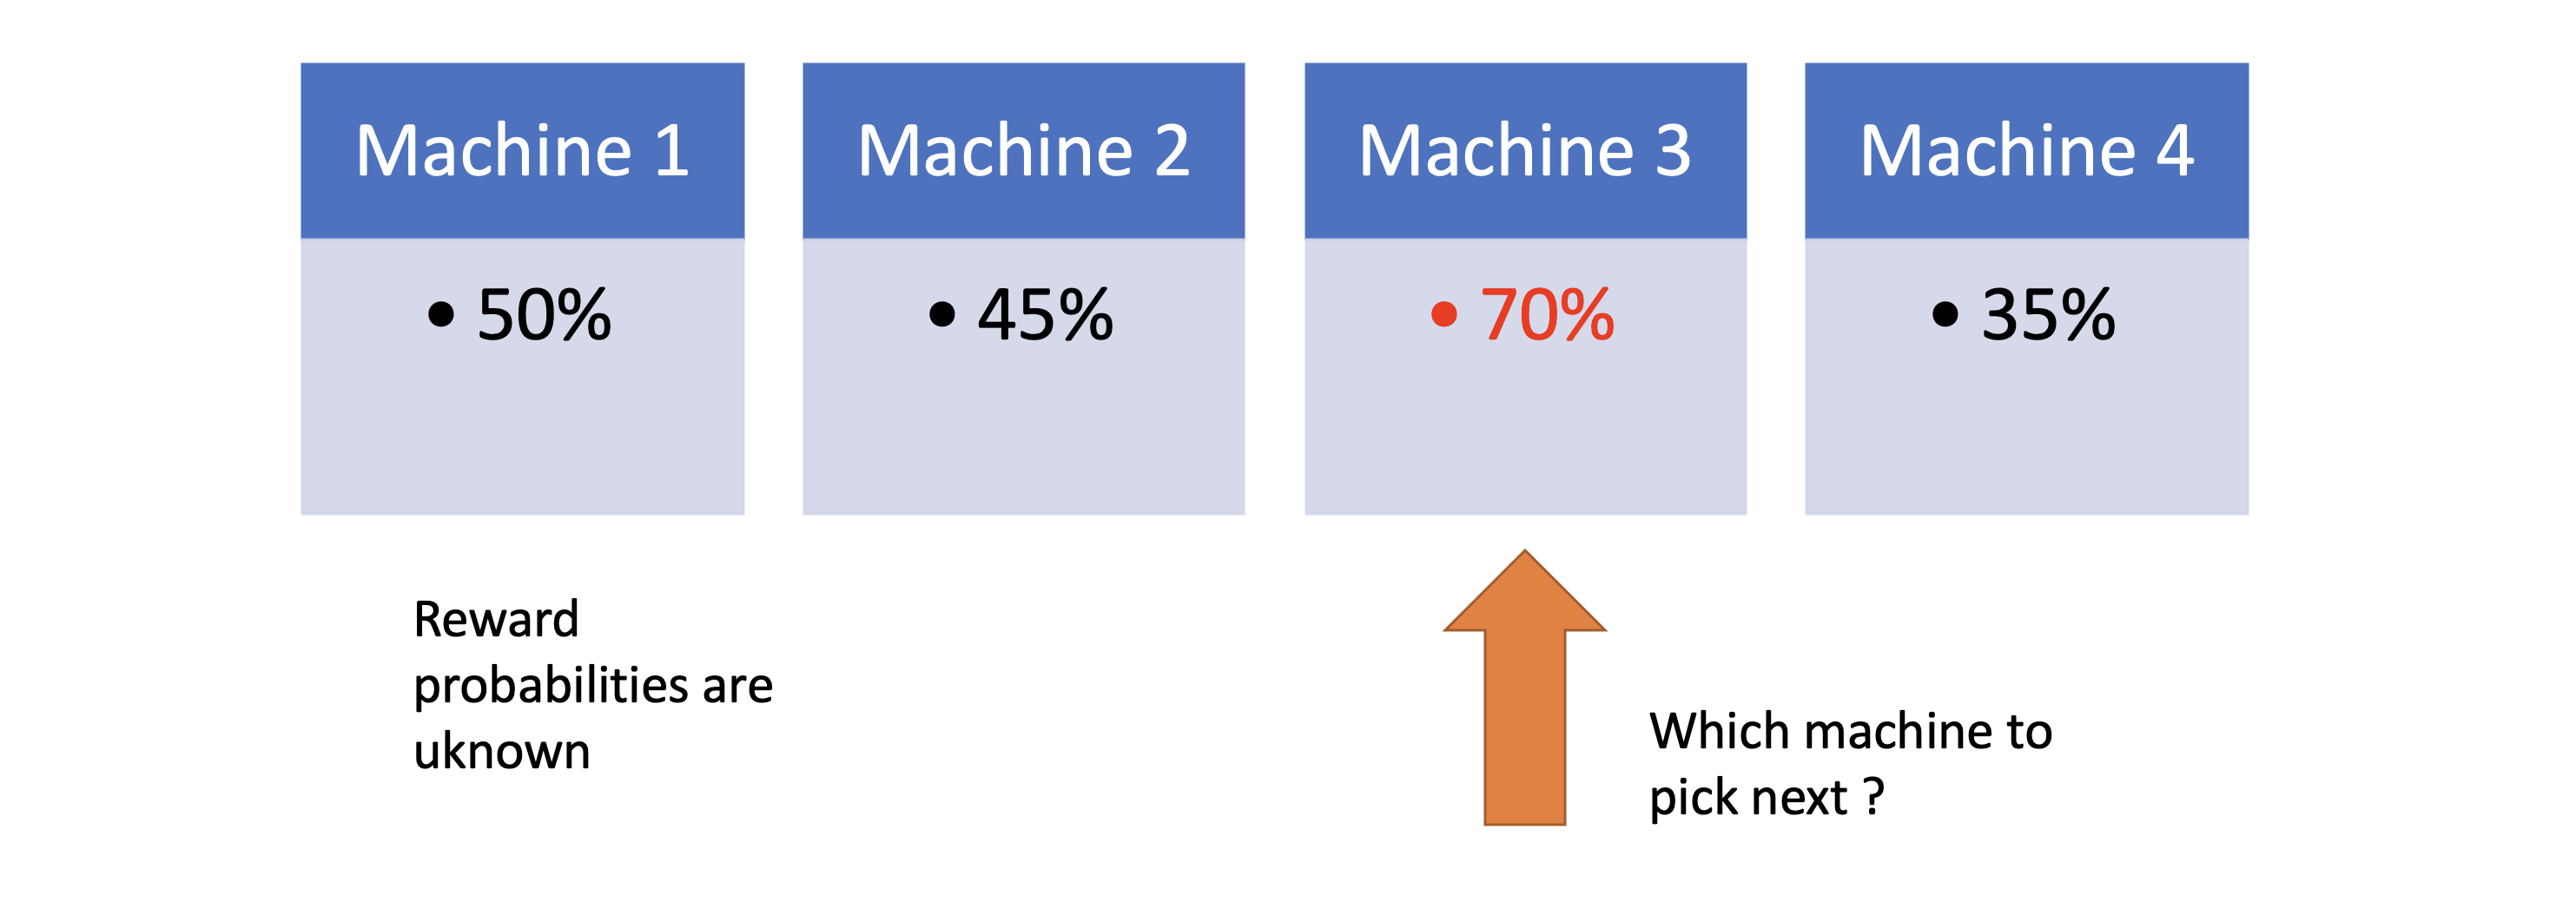

> Illustration of how a Bernoulli multi-armed bandit works. The reward probabilities are **unknown** to the player

## Bandit Strategies

### Approximate solutions

Many strategies exist which provide an approximate solution to the bandit problem. Semi-uniform strategies were the earliest (and simplest) strategies discovered to approximately solve the bandit problem. All those strategies have in common a greedy behavior where the *best* lever (based on previous observations) is always pulled except when a (uniformly) random action is taken.

* **$\epsilon$-greedy strategy**: The best lever is selected for a proportion $1 - \epsilon$ of the trials, and a lever is selected at random (with uniform probability) for a proportion $\epsilon$. A typical parameter value might be $\epsilon = 0.1$, but this can vary widely depending on circumstances and predilections.
* **$\epsilon$-first strategy**: A pure exploration phase is followed by a pure exploitation phase. For $N$ trials in total, the exploration phase occupies $\epsilon N$ trials and the exploitation phase $(1 - \epsilon) N$ trials. During the exploration phase, a lever is randomly selected (with uniform probability); during the exploitation phase, the best lever is always selected.
* **$\epsilon$-decreasing strategy**: Similar to the epsilon-greedy strategy, except that the value of $\epsilon$ decreases as the experiment progresses, resulting in highly explorative behaviour at the start and highly exploitative behaviour at the finish.
* **Adaptive $\epsilon$-greedy strategy based on value differences (VDBE)**: Similar to the epsilon-decreasing strategy, except that  epsilon is reduced on basis of the learning progress instead of manual tuning. High fluctuations in the value estimates lead to a high epsilon (high exploration, low exploitation); low fluctuations to a low epsilon (low exploration, high exploitation). Further improvements can be achieved by a softmax-weighted action selection in case of exploratory actions.
* **Adaptive $\epsilon$-greedy strategy based on Bayesian ensembles (Epsilon-BMC)**: An adaptive epsilon adaptation strategy for reinforcement learning similar to VBDE, with monotone convergence guarantees. In this framework, the epsilon parameter is viewed as the expectation of a posterior distribution weighting a greedy agent (that fully trusts the learned reward) and uniform learning agent (that distrusts the learned reward). This posterior is approximated using a suitable Beta distribution under the assumption of normality of observed rewards. In order to address the possible risk of decreasing epsilon too quickly, uncertainty in the variance of the learned reward is also modeled and updated using a normal-gamma model.
* **Contextual-$\epsilon$-greedy strategy**: Similar to the epsilon-greedy strategy, except that the value of $\epsilon$ is computed regarding the situation in experiment processes, which lets the algorithm be Context-Aware. It is based on dynamic exploration/exploitation and can adaptively balance the two aspects by deciding which situation is most relevant for exploration or exploitation, resulting in highly explorative behavior when the situation is not critical and highly exploitative behavior at critical situation.


### Optimal solutions

A major breakthrough was the construction of optimal population selection strategies, or *policies* (that possess uniformly maximum convergence rate to the population with highest mean) in the work described below.

* **UCBC (Historical Upper Confidence Bounds with clusters):** The algorithm adapts UCB for a new setting such that it can incorporate both clustering and historical information. The algorithm incorporates the historical observations by utilizing both in the computation of the observed mean rewards and the uncertainty term. The algorithm incorporates the clustering information by playing at two levels: first picking a cluster using a UCB-like strategy at each time step, and subsequently picking an arm within the cluster, again using a UCB-like strategy.
* **Thompson Sampling** : It consists in choosing the action that maximizes the expected reward with respect to a randomly drawn belief

#### Thompson sampling model

Consider a set of contexts $\mathcal{X}$, a set of actions $\mathcal{A}$, and rewards in $\mathbb{R}$. In each round, the player obtains a context $x \in \mathcal{X}$, plays an action $a \in \mathcal{A}$ and receives a reward $r \in \mathbb{R}$ following a distribution that depends on the context and the issued action. The aim of the player is to play actions such as to maximize the cumulative rewards.

The elements of Thompson sampling are as follows:
1. a likelihood function $P(r|\theta,a,x)$
2. a set $\Theta$ of parameters $\theta$ of the distribution of $r$
3. a prior distribution $P(\theta)$ on these parameters
4. past observations triplets $\mathcal{D} = \{(x; a; r)\}$
5. a posterior distribution $P(\theta|\mathcal{D}) \propto P(\mathcal{D}|\theta)P(\theta)$, where $P(\mathcal{D}|\theta)$ is the likelihood function.

Thompson sampling consists in playing the action $a^\ast \in \mathcal{A}$ according to the probability that it maximizes the expected reward, i.e. action $a^\ast$ is chosen with probability

$$ \int \mathbb{I} \left[ \mathbb{E}(r|a^\ast,x,\theta) = \max_{a'} \mathbb{E}(r|a',x,\theta) \right] P(\theta|\mathcal{D}) d\theta $$

where $\mathbb{I}$ is the indicator function.

In practice, the rule is implemented by sampling, in each round, parameters $\theta^\ast$ from the posterior $P(\theta|\mathcal{D})$, and choosing the action $a^\ast$ that maximizes $\mathbb{E}[r|\theta^\ast,a^\ast,x]$, i.e. the expected reward given the sampled parameters, the action and the current context. Conceptually, this means that the player instantiates their beliefs randomly in each round according to the posterior distribution, and then acts optimally according to them.  In most practical applications, it is computationally onerous to maintain and sample from a posterior distribution over models.  As such, Thompson sampling is often used in conjunction with approximate sampling techniques.

# Bandits in Practice

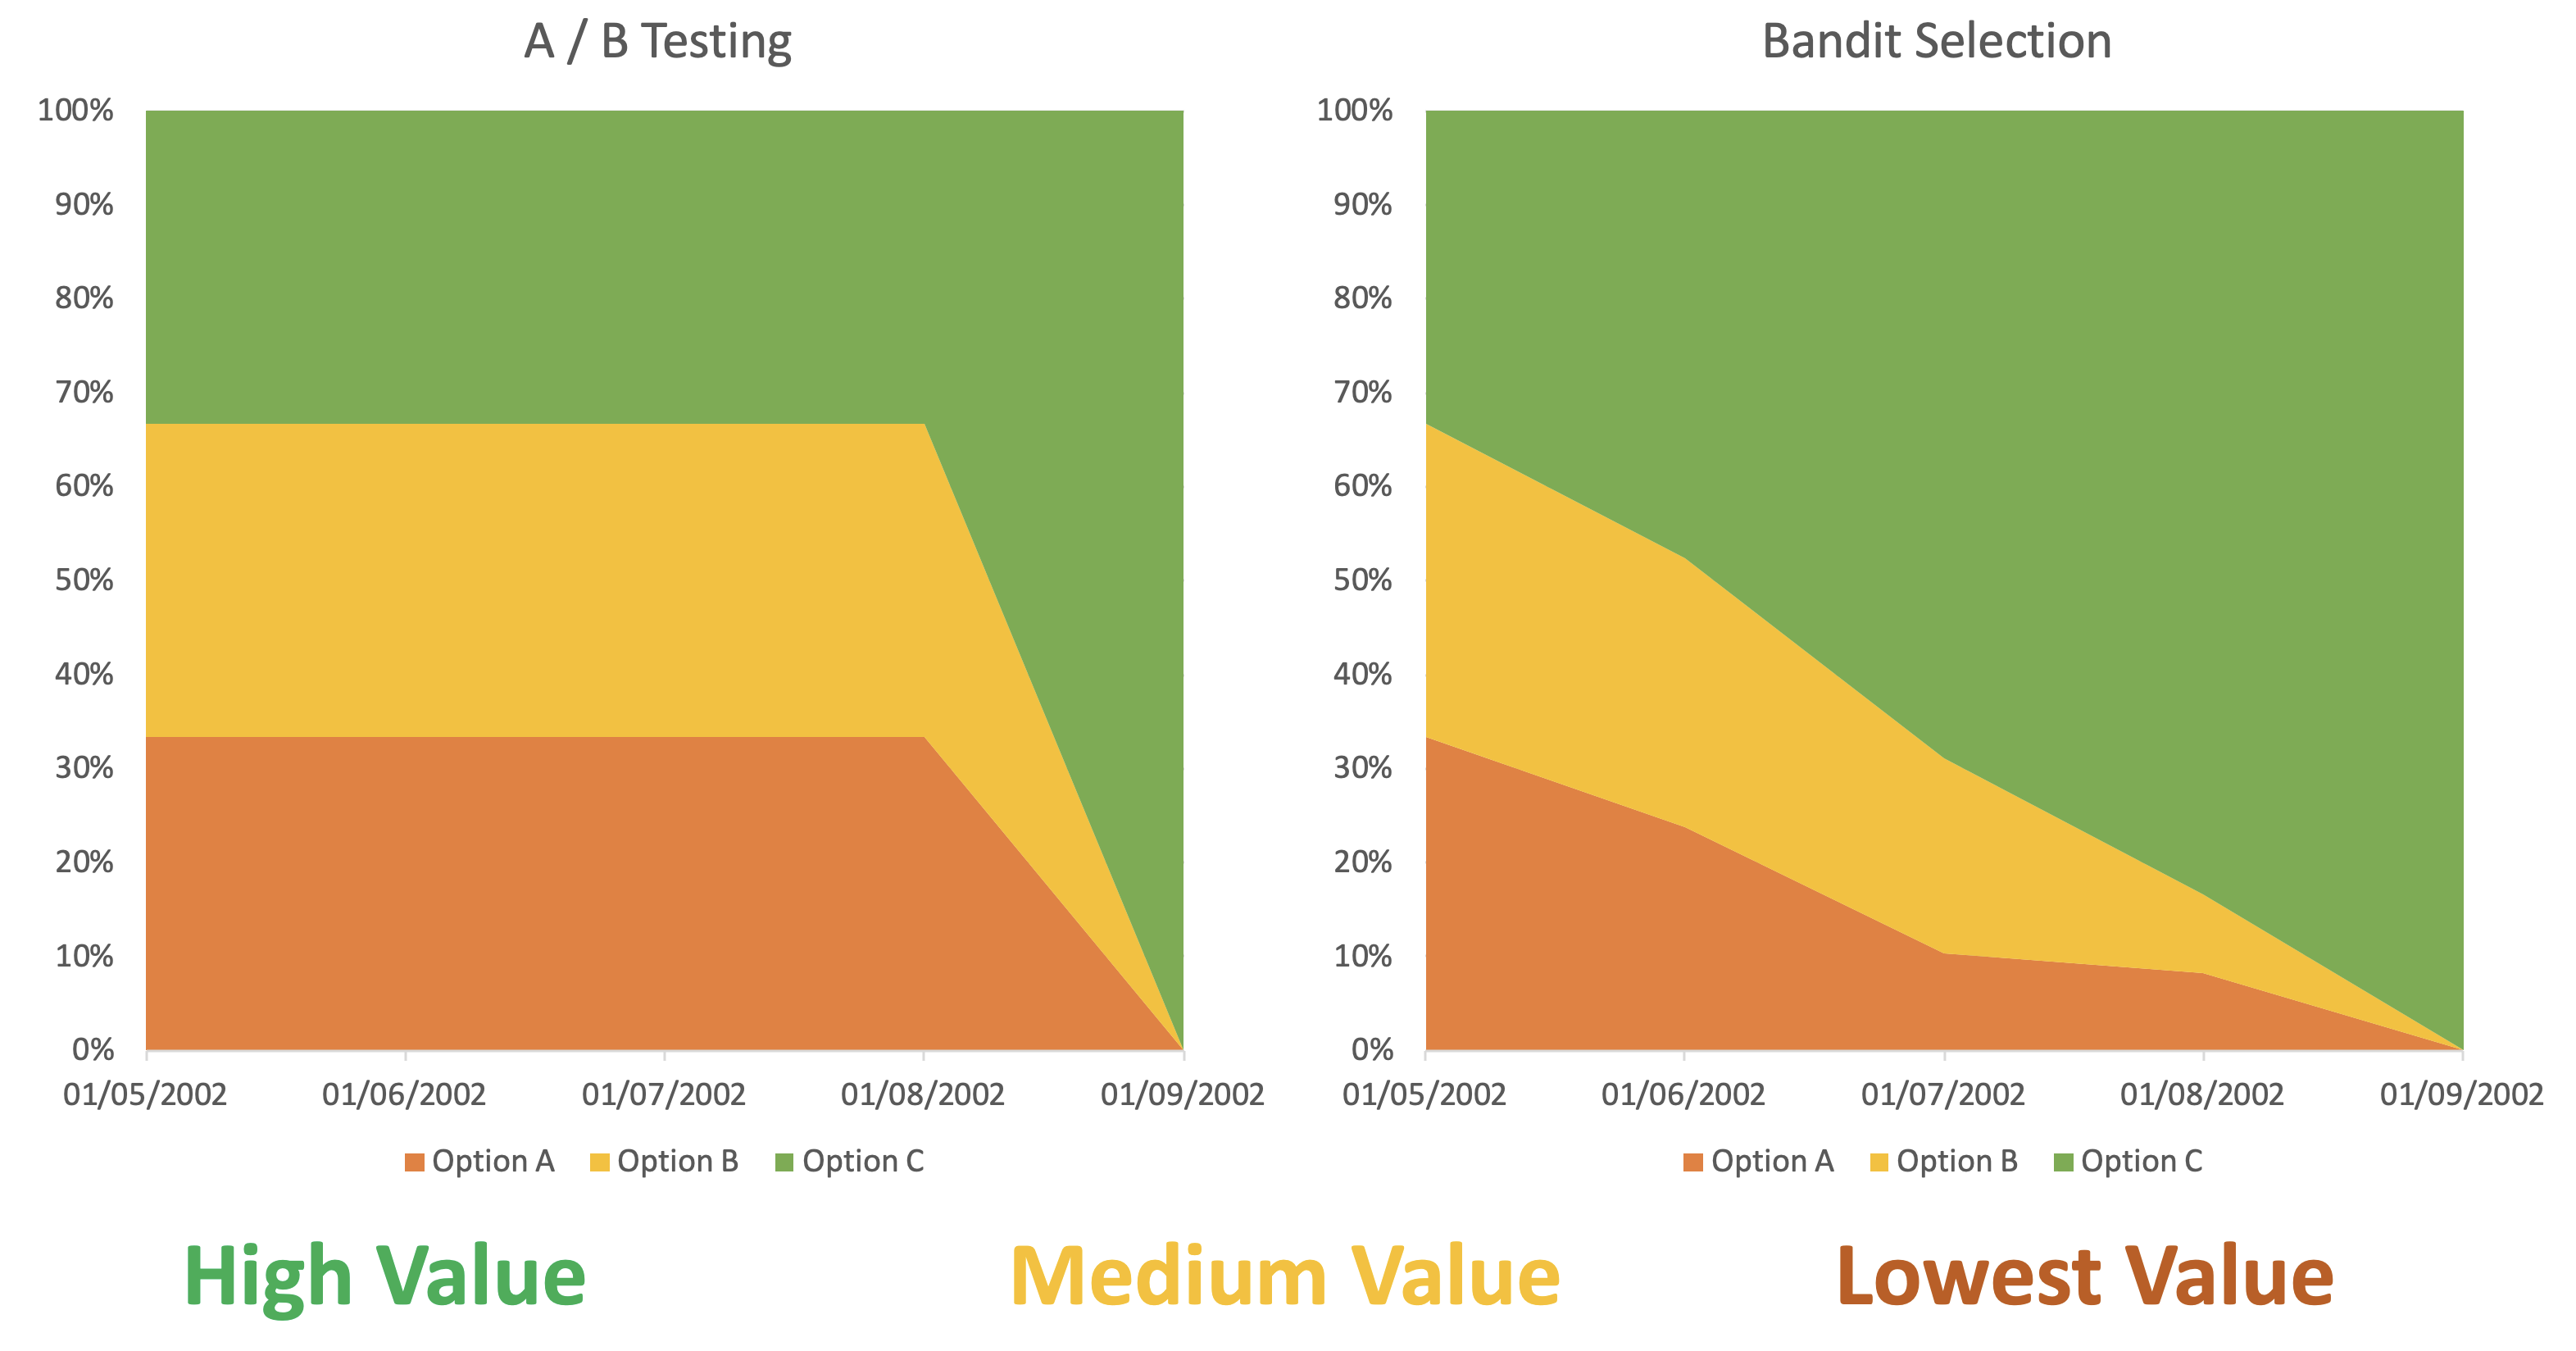

We can use Bandits as a better form of A/B testing, testing out variations of say a product on a website, or a few variations in a marketing campaign. As illustrated in the diagram above, A/B testing (e.g. for three options) would naïvely run them each, collect results and then we could select the option that had the highest value (perhaps here the most users that bought our product online or signed up to our form). Bandits allows us to search this space more effecitvely, and optomise the options as we collect data, to show a larger percentage of potential users the higher value option earlier, as illustrated, this is an illustrated example of regret minimization.

# Bandits in TF-Agents

TF-Agents supports modelling bandit problems with it's `tf_agents.bandits`. This supports bandit, agents, environments, networks, policies and specs.



In [2]:
from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step

tf.compat.v1.enable_resource_variables()
tf.compat.v1.enable_v2_behavior()
nest = tf.compat.v2.nest

The Multi-Armed Bandit problem (MAB) is a special case of Reinforcement Learning: an agent collects rewards in an environment by taking some actions after observing some state of the environment. The main difference between general RL and MAB is that in MAB, we assume that the action taken by the agent does not influence the next state of the environment. Therefore, agents do not model state transitions, credit rewards to past actions, or "plan ahead" to get to reward-rich states.

As in other RL domains, the goal of a MAB *agent* is to find a *policy* that collects as much reward as possible. It would be a mistake, however, to always try to exploit the action that promises the highest reward, because then there is a chance that we miss out on better actions if we do not explore enough. This is the main problem to be solved in (MAB), often called the *exploration-exploitation dilemma*.

# Environments

In TF-Agents, the environment class serves the role of giving information on the current state (this is called **observation** or **context**), receiving an action as input, performing a state transition, and outputting a reward. This class also takes care of resetting when an episode ends, so that a new episode can start. This is realized by calling a `reset` function when a state is labelled as "last" of the episode.

As mentioned above, MAB differs from general RL in that actions do not influence the next observation. Another difference is that in Bandits, there are no "episodes": every time step starts with a new observation, independently of previous time steps.

To make sure observations are independent and to abstract away the concept of RL episodes, we introduce subclasses of `PyEnvironment` and `TFEnvironment`: `BanditPyEnvironment` and `BanditTFEnvironment`. These classes expose two private member functions that remain to be implemented by the user:

```python
@abc.abstractmethod
def _observe(self):
```
and
```python
@abc.abstractmethod
def _apply_action(self, action):
```
The `_observe` function returns an observation. Then, the policy chooses an action based on this observation. The `_apply_action` receives that action as an input, and returns the corresponding reward. These private member functions are called by the functions `reset` and `step`, respectively.

In [3]:
class BanditPyEnvironment(py_environment.PyEnvironment):

    def __init__(self, observation_spec, action_spec):
        self._observation_spec = observation_spec
        self._action_spec = action_spec
        super(BanditPyEnvironment, self).__init__()

    # Helper functions.
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _empty_observation(self):
        return tf.nest.map_structure(lambda x: np.zeros(x.shape, x.dtype),
                                     self.observation_spec())

    # These two functions below should not be overridden by subclasses.
    def _reset(self):
        """Returns a time step containing an observation."""
        return ts.restart(self._observe(), batch_size=self.batch_size)

    def _step(self, action):
        """Returns a time step containing the reward for the action taken."""
        reward = self._apply_action(action)
        return ts.termination(self._observe(), reward)

    # These two functions below are to be implemented in subclasses.
    @abc.abstractmethod
    def _observe(self):
        """Returns an observation."""

    @abc.abstractmethod
    def _apply_action(self, action):
        """Applies `action` to the Environment and returns the corresponding reward.
        """

The above interim abstract class implements `PyEnvironment`'s `_reset` and `_step` functions and exposes the abstract functions `_observe` and `_apply_action` to be implemented by subclasses.

## A Simple Example Environment Class

The following class gives a very simple environment for which the observation is a random integer between -2 and 2, there are 3 possible actions (0, 1, 2), and the reward is the product of the action and the observation.

In [4]:
class SimplePyEnvironment(BanditPyEnvironment):

    def __init__(self):
        action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
        observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.int32, minimum=-2, maximum=2, name='observation')
        super(SimplePyEnvironment, self).__init__(
            observation_spec, action_spec)

    def _observe(self):
        self._observation = np.random.randint(-2, 3, (1,), dtype=np.int32)
        return self._observation

    def _apply_action(self, action):
        return action * self._observation

Now we can use this environment to get observations, and receive rewards for our actions.

In [5]:
environment = SimplePyEnvironment()
observation = environment.reset().observation
print("observation: %d" % observation)

action = 2  # @param

print("action: %d" % action)
reward = environment.step(action).reward
print("reward: %f" % reward)

observation: 2
action: 2
reward: 4.000000


## TF Environments

One can define a bandit environment by subclassing `BanditTFEnvironment`, or, similarly to RL environments, one can define a `BanditPyEnvironment` and wrap it with `TFPyEnvironment`. For the sake of simplicity, we go with the latter option in this tutorial.

In [6]:
tf_environment = tf_py_environment.TFPyEnvironment(environment)

# Policies

A *policy* in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.

As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `tf_policy.Base`. Here we elect to go with the direct method.

Since this example is quite simple, we can define the optimal policy manually. The action only depends on the sign of the observation, 0 when is negative and 2 when is positive.

In [7]:
class SignPolicy(tf_policy.Base):
    def __init__(self):
        observation_spec = tensor_spec.BoundedTensorSpec(
            shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
        time_step_spec = ts.time_step_spec(observation_spec)

        action_spec = tensor_spec.BoundedTensorSpec(
            shape=(), dtype=tf.int32, minimum=0, maximum=2)

        super(SignPolicy, self).__init__(time_step_spec=time_step_spec,
                                         action_spec=action_spec)

    def _distribution(self, time_step):
        pass

    def _variables(self):
        return ()

    def _action(self, time_step, policy_state, seed):
        observation_sign = tf.cast(
            tf.sign(time_step.observation[0]), dtype=tf.int32)
        action = observation_sign + 1
        return policy_step.PolicyStep(action, policy_state)

Now we can request an observation from the environment, call the policy to choose an action, then the environment will output the reward:

In [8]:
sign_policy = SignPolicy()

current_time_step = tf_environment.reset()
print('Observation:')
print(current_time_step.observation)
action = sign_policy.action(current_time_step).action
print('\nAction:')
print(action)
reward = tf_environment.step(action).reward
print('\nReward:')
print(reward)

Observation:
tf.Tensor([[1]], shape=(1, 1), dtype=int32)

Action:
tf.Tensor([2], shape=(1,), dtype=int32)

Reward:
tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


The way bandit environments are implemented ensures that every time we take a step, we not only receive the reward for the action we took, but also the next observation.

In [9]:
step = tf_environment.reset()
action = 1
next_step = tf_environment.step(action)
reward = next_step.reward
next_observation = next_step.observation
print("Reward: ")
print(reward)
print("\nNext observation:")
print(next_observation)

Reward: 
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)

Next observation:
tf.Tensor([[-1]], shape=(1, 1), dtype=int32)


# Agents

Now that we have bandit environments and bandit policies, it is time to also define bandit agents, that take care of changing the policy based on training samples.

The API for bandit agents does not differ from that of RL agents: the agent just needs to implement the `_initialize` and `_train` methods, and define a `policy` and a `collect_policy`.

## A More Complicated Environment

Before we write our bandit agent, we need to have an environment that is a bit harder to figure out. To spice up things just a little bit, the next environment will either always give `reward = observation * action` or `reward = -observation * action`. This will be decided when the environment is initialized.

In [10]:
class TwoWayPyEnvironment(BanditPyEnvironment):

    def __init__(self):
        action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
        observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.int32, minimum=-2, maximum=2, name='observation')

        # Flipping the sign with probability 1/2.
        self._reward_sign = 2 * np.random.randint(2, dtype=np.int32) - 1
        print("reward sign:")
        print(self._reward_sign)

        super(TwoWayPyEnvironment, self).__init__(
            observation_spec, action_spec)

    def _observe(self):
        self._observation = np.random.randint(-2, 3, (1,), dtype=np.int32)
        return self._observation

    def _apply_action(self, action):
        return self._reward_sign * action * self._observation[0]


two_way_tf_environment = tf_py_environment.TFPyEnvironment(
    TwoWayPyEnvironment())

reward sign:
1


## A More Complicated Policy

A more complicated environment calls for a more complicated policy. We need a policy that detects the behavior of the underlying environment. There are three situations that the policy needs to handle:

0.   The agent has not detected know yet which version of the environment is running.
1.   The agent detected that the original version of the environment is running.
2.   The agent detected that the flipped version of the environment is running.

We define a `tf_variable` named `_situation` to store this information encoded as values in `[0, 2]`, then make the policy behave accordingly.

In [11]:
class TwoWaySignPolicy(tf_policy.Base):
    def __init__(self, situation):
        observation_spec = tensor_spec.BoundedTensorSpec(
            shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
        action_spec = tensor_spec.BoundedTensorSpec(
            shape=(), dtype=tf.int32, minimum=0, maximum=2)
        time_step_spec = ts.time_step_spec(observation_spec)
        self._situation = situation
        super(TwoWaySignPolicy, self).__init__(time_step_spec=time_step_spec,
                                               action_spec=action_spec)

    def _distribution(self, time_step):
        pass

    def _variables(self):
        return [self._situation]

    def _action(self, time_step, policy_state, seed):
        sign = tf.cast(tf.sign(time_step.observation[0, 0]), dtype=tf.int32)

        def case_unknown_fn():
            # Choose 1 so that we get information on the sign.
            return tf.constant(1, shape=(1,))

        # Choose 0 or 2, depending on the situation and the sign of the observation.
        def case_normal_fn():
            return tf.constant(sign + 1, shape=(1,))

        def case_flipped_fn():
            return tf.constant(1 - sign, shape=(1,))

        cases = [(tf.equal(self._situation, 0), case_unknown_fn),
                 (tf.equal(self._situation, 1), case_normal_fn),
                 (tf.equal(self._situation, 2), case_flipped_fn)]
        action = tf.case(cases, exclusive=True)
        return policy_step.PolicyStep(action, policy_state)

## The Agent

Now it's time to define the agent that detects the sign of the environment and sets the policy appropriately.

In [12]:
class SignAgent(tf_agent.TFAgent):
    def __init__(self):
        self._situation = tf.compat.v2.Variable(0, dtype=tf.int32)
        policy = TwoWaySignPolicy(self._situation)
        time_step_spec = policy.time_step_spec
        action_spec = policy.action_spec
        super(SignAgent, self).__init__(time_step_spec=time_step_spec,
                                        action_spec=action_spec,
                                        policy=policy,
                                        collect_policy=policy,
                                        train_sequence_length=None)

    def _initialize(self):
        return tf.compat.v1.variables_initializer(self.variables)

    def _train(self, experience, weights=None):
        observation = experience.observation
        action = experience.action
        reward = experience.reward

        # We only need to change the value of the situation variable if it is
        # unknown (0) right now, and we can infer the situation only if the
        # observation is not 0.
        needs_action = tf.logical_and(tf.equal(self._situation, 0),
                                      tf.not_equal(reward, 0))

        def new_situation_fn():
            """This returns either 1 or 2, depending on the signs."""
            return (3 - tf.sign(tf.cast(observation[0, 0, 0], dtype=tf.int32) *
                                tf.cast(action[0, 0], dtype=tf.int32) *
                                tf.cast(reward[0, 0], dtype=tf.int32))) / 2

        new_situation = tf.cond(needs_action,
                                new_situation_fn,
                                lambda: self._situation)
        new_situation = tf.cast(new_situation, dtype=tf.int32)
        tf.compat.v1.assign(self._situation, new_situation)
        return tf_agent.LossInfo((), ())


sign_agent = SignAgent()

In the above code, the agent defines the policy, and the variable `situation` is shared by the agent and the policy.

Also, the parameter `experience` of the `_train` function is a trajectory:

# Trajectories

In TF-Agents, `trajectories` are named tuples that contain samples from previous steps taken. These samples are then used by the agent to train and update the policy. In RL, trajectories must contain information about the current state, the next state, and whether the current episode has ended. Since in the Bandit world we do not need these things, we set up a helper function to create a trajectory:

In [13]:
def trajectory_for_bandit(initial_step, action_step, final_step):
    return trajectory.Trajectory(observation=tf.expand_dims(initial_step.observation, 0),
                                 action=tf.expand_dims(action_step.action, 0),
                                 policy_info=action_step.info,
                                 reward=tf.expand_dims(final_step.reward, 0),
                                 discount=tf.expand_dims(
                                     final_step.discount, 0),
                                 step_type=tf.expand_dims(
                                     initial_step.step_type, 0),
                                 next_step_type=tf.expand_dims(final_step.step_type, 0))

# Training an Agent

Now all the pieces are ready for training our bandit agent.

In [14]:
step = two_way_tf_environment.reset()
for _ in range(10):
    action_step = sign_agent.collect_policy.action(step)
    next_step = two_way_tf_environment.step(action_step.action)
    experience = trajectory_for_bandit(step, action_step, next_step)
    sign_agent.train(experience)
    step = next_step

From the output one can see that after the second step (unless the observation was 0 in the first step), the policy chooses the action in the right way and thus the reward collected is always non-negative.

# A Real Contextual Bandit Example

Lets use a pre-implemented environment and agents of the [TF-Agents Bandits library](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits).

In [15]:
from tf_agents.bandits.agents import linear_thompson_sampling_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

## Stationary Stochastic Environment with Linear Payoff Functions

The environment used in this example is the `StationaryStochasticPyEnvironment`. This environment takes as parameter a (usually noisy) function for giving observations (context), and for every arm takes an (also noisy) function that computes the reward based on the given observation. In our example, we sample the context uniformly from a d-dimensional cube, and the reward functions are linear functions of the context, plus some Gaussian noise.

In [16]:
batch_size = 2  # @param
arm0_param = [-3, 0, 1, -2]  # @param
arm1_param = [1, -2, 3, 0]  # @param
arm2_param = [0, 0, 1, 1]  # @param


def context_sampling_fn(batch_size):
    """Contexts from [-10, 10]^4."""
    def _context_sampling_fn():
        return np.random.randint(-10, 10, [batch_size, 4]).astype(np.float32)
    return _context_sampling_fn


class LinearNormalReward(object):
    """A class that acts as linear reward function when called."""

    def __init__(self, theta, sigma):
        self.theta = theta
        self.sigma = sigma

    def __call__(self, x):
        mu = np.dot(x, self.theta)
        return np.random.normal(mu, self.sigma)


arm0_reward_fn = LinearNormalReward(arm0_param, 1)
arm1_reward_fn = LinearNormalReward(arm1_param, 1)
arm2_reward_fn = LinearNormalReward(arm2_param, 1)

environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn],
        batch_size=batch_size))

## The Linear Thompson Sampling Agent

The agent below implements the [Thompson Sampling Agent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/linear_thompson_sampling_agent/LinearThompsonSamplingAgent).

Paper : [Thompson Sampling for Contextual Bandits with Linear Payoffs](https://arxiv.org/abs/1209.3352), explaination is above in the introduction. We recommend to use this agent, or a Linear UCB bandit algorithm, such as the [LinearUCBAgent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent/LinearUCBAgent).

In [17]:
observation_spec = tensor_spec.TensorSpec([4], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = linear_thompson_sampling_agent.LinearThompsonSamplingAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec)

## Regret Metric

Bandits' most important metric is **regret**, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The `RegretMetric` thus needs a *baseline_reward_fn* function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [18]:
def compute_optimal_reward(observation):
    expected_reward_for_arms = [
        tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
        tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
        tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32))]
    optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
    return optimal_action_reward


regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)

## Training

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data with the help of a *driver*, and train the agent on the data.

Note that there are two parameters that together specify the number of steps taken. `num_iterations` specifies how many times we run the trainer loop, while the driver will take `steps_per_loop` steps per iteration. The main reason behind keeping both of these parameters is that some operations are done per iteration, while some are done by the driver in every step. For example, the agent's `train` function is only called once per iteration. The trade-off here is that if we train more often then our policy is "fresher", on the other hand, training in bigger batches might be more time efficient.

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


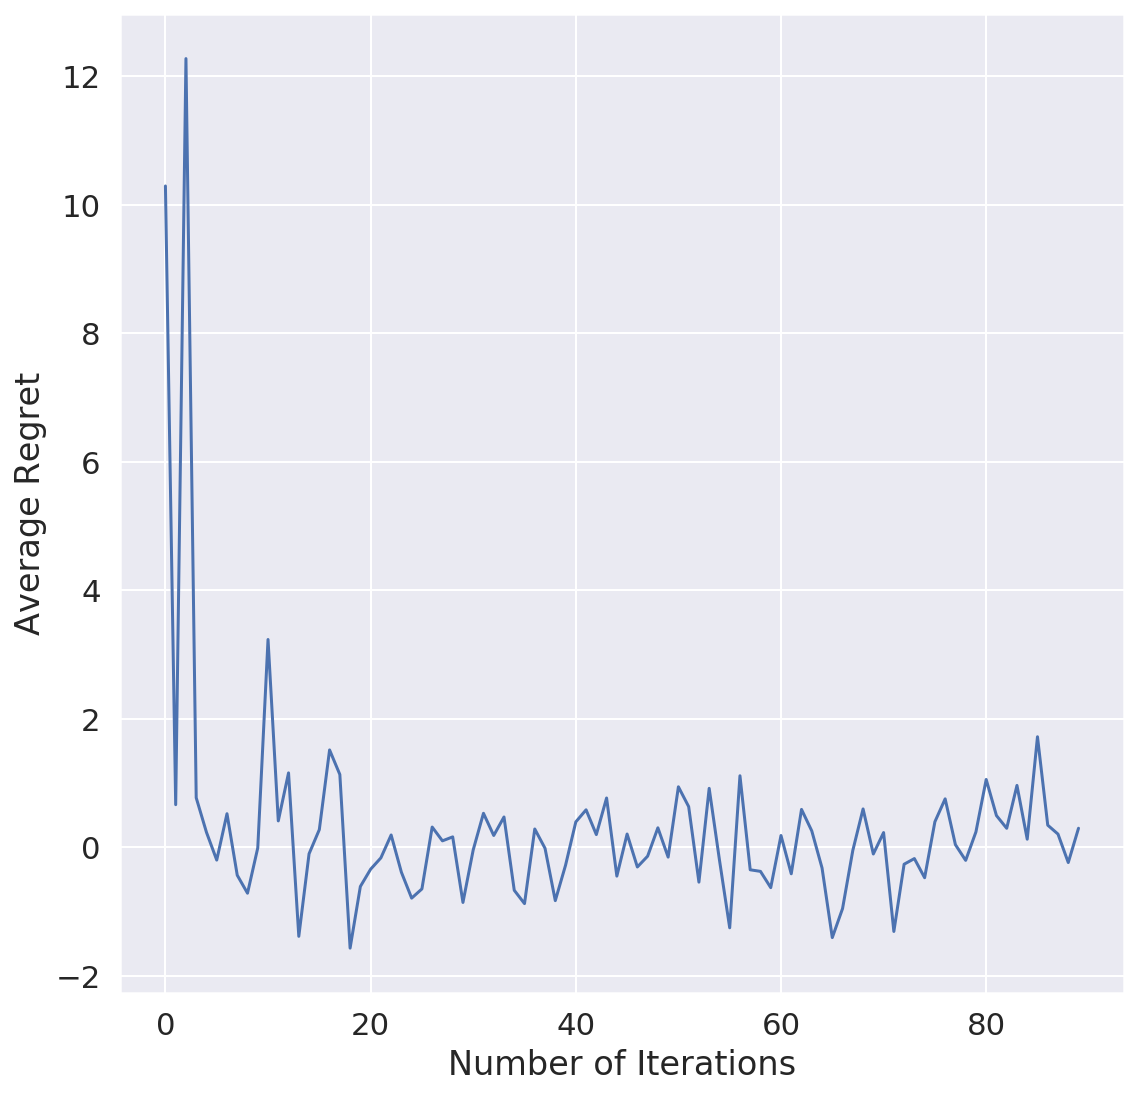

In [19]:
num_iterations = 90  # @param
steps_per_loop = 1  # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')
plt.show()

The resulting plot shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation. We can now extend this framework to our problem in practice.

# Uncertainty in Reinforcement Learning

Particulary in Q-learning we can model uncertainty (in the Q-value function) by using a *Distributional* Bellman equation, instead of using our so far used approximate expectation (that we have so far seen). This was first introduced by the [*Categorical DQN (C51)*](https://arxiv.org/pdf/1707.06887.pdf).

Lets implement and train a *Categorical DQN (C51)* with TF-Agents

In [20]:
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

In [21]:
env_name = "LunarLander-v2" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (128,128,128)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 3  # @param {type:"integer"}
eval_interval = 3000  # @param {type:"integer"}

## Environment

Lets load two enviroments one for training and one for evaluation. Here we will use the **LunarLander-v2** [enviornment](https://gym.openai.com/envs/LunarLander-v2/), where we have to navigate a lundar lander to its landing pad between the set flags. The landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

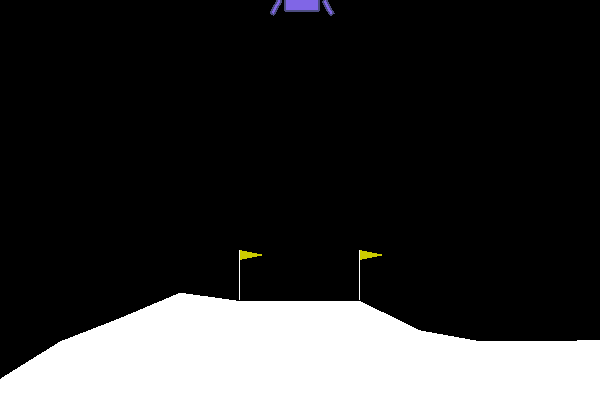

In [22]:
env = suite_gym.load(env_name)
env.reset()
# Lets see a possible starting state
PIL.Image.fromarray(env.render())

In [23]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

C51 is a Q-learning algorithm based on DQN. Like DQN, it can be used on any environment with a discrete action space.

The main difference between C51 and DQN is that rather than simply predicting the Q-value for each state-action pair, C51 predicts a histogram model for the probability distribution of the Q-value:

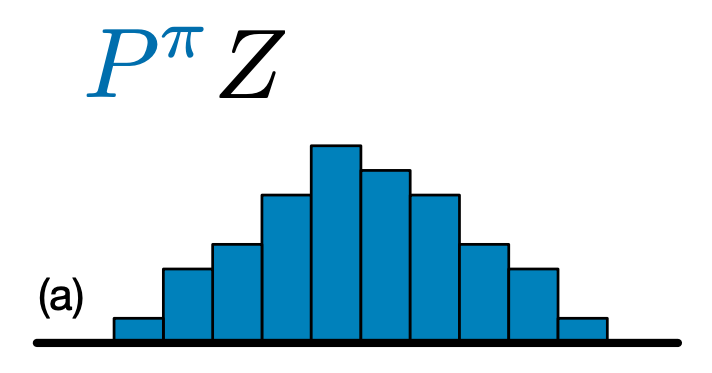

By learning the distribution rather than simply the expected value, the algorithm is able to stay more stable during training, leading to improved final performance. This is particularly true in situations with bimodal or even multimodal value distributions, where a single average does not provide an accurate picture.

In order to train on probability distributions rather than on values, C51 must perform some complex distributional computations in order to calculate its loss function. However TF-Agents helps us with this.

To create a C51 Agent, we first need to create a `CategoricalQNetwork`. The API of the `CategoricalQNetwork` is the same as that of the `QNetwork`, except that there is an additional argument `num_atoms`. This represents the number of support points in our probability distribution estimates. (The above image includes 10 support points, each represented by a vertical blue bar.) As you can tell from the name, the default number of atoms is 51.


In [24]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.

Note that one other significant difference from vanilla `DqnAgent` is that we now need to specify `min_q_value` and `max_q_value` as arguments. These specify the most extreme values of the support (in other words, the most extreme of the 51 atoms on either side). Make sure to choose these appropriately for your particular environment. Here we use -20 and 20.

In [25]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

One last thing to note is that we also added an argument to use n-step updates with $n$ = 2. In single-step Q-learning ($n$ = 1), we only compute the error between the Q-values at the current time step and the next time step using the single-step return (based on the Bellman optimality equation). The single-step return is defined as:

$G_t = R_{t + 1} + \gamma V(s_{t + 1})$

where we define $V(s) = \max_a{Q(s, a)}$.

N-step updates involve expanding the standard single-step return function $n$ times:

$G_t^n = R_{t + 1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \dots + \gamma^n V(s_{t + n})$

N-step updates enable the agent to bootstrap from further in the future, and with the right value of $n$, this often leads to faster learning.

Although C51 and n-step updates are often combined with prioritized replay to form the core of the [Rainbow agent](https://arxiv.org/pdf/1710.02298.pdf), we saw no measurable improvement from implementing prioritized replay. Moreover, we find that when combining our C51 agent with n-step updates alone, our agent performs as well as other Rainbow agents on the sample of Atari environments we've tested.

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [26]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

-218.34021

## Data Collection

As in the DQN tutorial, set up the replay buffer and the initial data collection with the random policy.

In [27]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)


def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)


for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [28]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for iteration in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience)

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('[{0}] step = {1}: loss = {2}'.format(iteration, step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('[{0}] step = {1}: Average Return = {2:.2f}'.format(iteration, step, avg_return))
        returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
[199] step = 200: loss = 3.0104289054870605
[399] step = 400: loss = 3.7165422439575195
[599] step = 600: loss = 3.2233362197875977
[799] step = 800: loss = 3.004636764526367
[999] step = 1000: loss = 3.0882391929626465
[1199] step = 1200: loss = 3.001344680786133
[1399] step = 1400: loss = 2.67657470703125
[1599] step = 1600: loss = 2.840812921524048
[1799] step = 1800: loss = 2.9715704917907715
[1999] step = 2000: loss = 2.72274112701416
[2199] step = 2200: loss = 3.0459656715393066
[2399] step = 2400: loss = 2.865429639816284
[2599] step = 2600: loss = 2.9828763008117676
[2799] step = 2800: loss = 2.6324288845062256
[2999] step = 3000: loss = 2.635241985321045
[2999] step = 3000: Average Return = -175.03
[3199] step = 3200: loss = 2.8711886405944824
[33

## Visualization


### Plots

We can plot return vs global steps to see the performance of our agent. In `LunarLander-v2`, the reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

(-524.890149307251, 550)

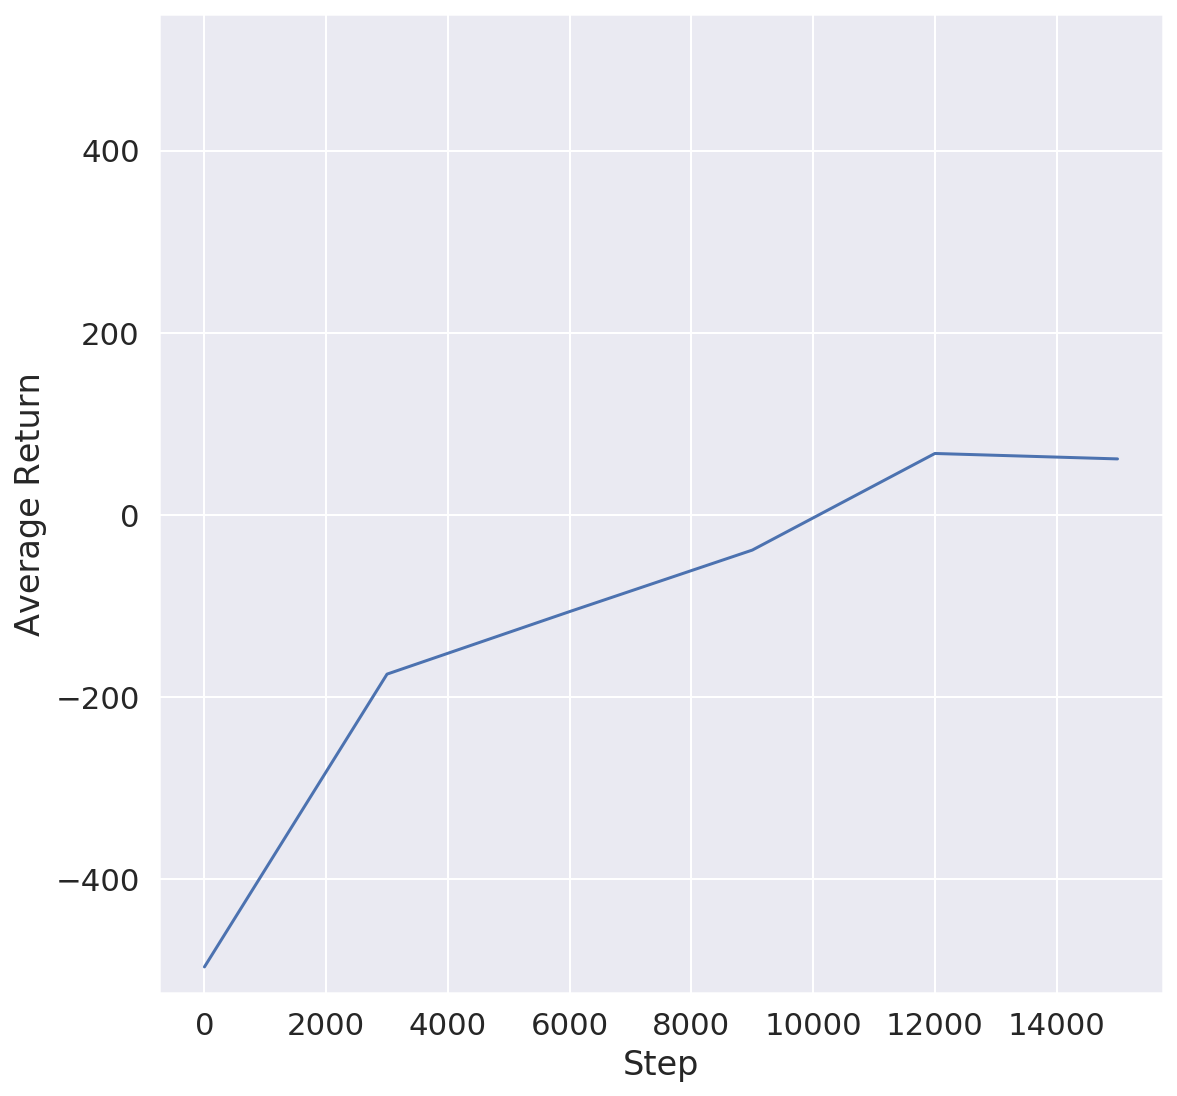

In [29]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

In [30]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [31]:
num_episodes = 3
video_filename = 'lunar_lander.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
    for _ in range(num_episodes):
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = agent.policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())

embed_mp4(video_filename)

C51 tends to do slightly better than DQN in general, however the difference between the two agents becomes more and more significant in increasingly complex environments. For example, on the full Atari 2600 benchmark, C51 demonstrates a mean score improvement of 126% over DQN after normalizing with respect to a random agent. Additional improvements can be gained by including n-step updates.

For a deeper dive into the C51 algorithm, see [A Distributional Perspective on Reinforcement Learning (2017)](https://arxiv.org/pdf/1707.06887.pdf).